In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

# FRED API Key
API_KEY = "21383490f9deb726c398991e6d6cd89e"

# Define FRED series IDs for Treasury yields
FRED_SERIES = {
    "1M": "DGS1MO",
    "3M": "DGS3MO",
    "6M": "DGS6MO",
    "1Y": "DGS1",
    "2Y": "DGS2",
    "3Y": "DGS3",
    "5Y": "DGS5",
    "7Y": "DGS7",
    "10Y": "DGS10",
    "20Y": "DGS20",
    "30Y": "DGS30",
}

# Define date range
START_DATE = "2023-01-01"
END_DATE = "2023-12-31"

# Function to pull data from FRED
def fetch_fred_data(series_id, start_date, end_date, api_key):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    response = requests.get(url, params=params)
    data = response.json()
    observations = data.get("observations", [])
    return pd.DataFrame(
        [(obs["date"], float(obs["value"])) for obs in observations if obs["value"] != "."],
        columns=["date", series_id]
    ).set_index("date")

# Pull data for all tenors and store in DataFrame
data_frames = []
for tenor, series_id in FRED_SERIES.items():
    df = fetch_fred_data(series_id, START_DATE, END_DATE, API_KEY)
    data_frames.append(df)

# Merge all data into a single DataFrame
treasury_data = pd.concat(data_frames, axis=1)
treasury_data.index = pd.to_datetime(treasury_data.index)


In [5]:
import numpy as np
import pandas as pd
import os
import io
from google.colab import files

#Upload file
uploaded = files.upload()

uploaded_file_name = list(uploaded.keys())[0]

#Load bond yields
bond_yields = pd.read_excel(io.BytesIO(uploaded['Part 1. bonds_yields (2).xlsx']), engine='openpyxl')

#Load treasury data

#Define function
def interpolate_treasury_yield(wal, treasury_data):
  #Extract tenors and yields
  tenors = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
  yields = treasury_data.iloc[0].values

  #Use numpy interploation function
  return np.interp(wal, tenors, yields)

#Calc spreads of bonds
spreads = []
for index, bond in bond_yields.iterrows():
  wal = bond['WAL (years)']
  bond_yield = bond['Yield (%)']
  interpolated_yield = interpolate_treasury_yield(wal, treasury_data)
  spread = bond_yield - interpolated_yield
  spreads.append(spread)

#Add spreads to dataframe
bond_yields['Spread'] = spreads


Saving Part 1. bonds_yields.xlsx to Part 1. bonds_yields (2).xlsx


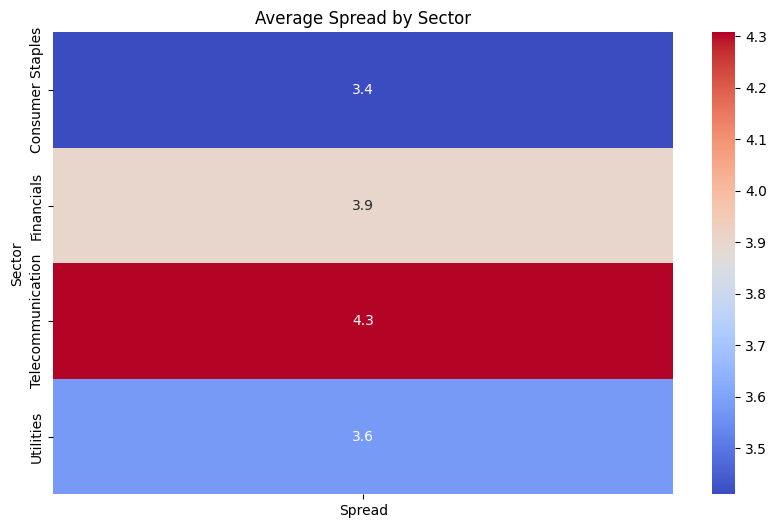

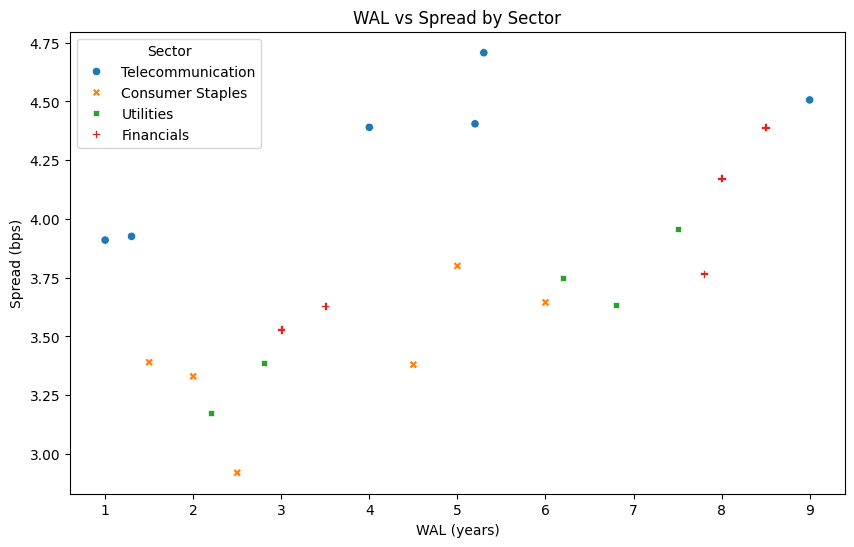

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


#Pivot table
heatmap_data = bond_yields.pivot_table(index="Sector", values="Spread", aggfunc="mean")

if heatmap_data.empty:
  print("Heatmap data is empty.")
else:
  #Create heatmap
  plt.figure(figsize=(10, 6))
  sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
  plt.title("Average Spread by Sector")
  plt.show()

#Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=bond_yields, x="WAL (years)", y="Spread", hue="Sector", style="Sector")
plt.title("WAL vs Spread by Sector")
plt.xlabel("WAL (years)")
plt.ylabel("Spread (bps)")
plt.show()